In [1]:
import pyaudio
import sys
import audioop
import struct
import numpy as np
import matplotlib.pyplot as plt
from pydub import AudioSegment
import wave
from scipy.signal import argrelextrema, gaussian
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

C:\ProgramData\Anaconda3\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
class TapDetector():
    def __init__(this,channels,rate,index,frames,chunk,tapSize):
        this.audio = pyaudio.PyAudio()
        this.freqFrames = np.full((tapSize,chunk),None,dtype='float64')
        this.frames = np.zeros(tapSize)
        this.all = []
        this.tapSize = tapSize
        this.currentFrame = 0
        this.chunk = chunk
        this.rate = rate
        this.cooldown =0
        this.trainingSets = []
        this.negativeTrainingSet = []
        this.clf = None
        #this.classifier = make_pipeline(StandardScaler(), SVC(gamma='auto'))
        this.classifier = DecisionTreeClassifier(max_depth=5)
        #this.classifier = KNeighborsClassifier(3)
        this.stream = this.audio.open(format = pyaudio.paInt16,
                                              channels = channels,
                                              rate = rate,
                                              input = True,
                                              input_device_index = index,
                                              frames_per_buffer = frames)
        #FILE READING
        this.wavFile = None
    
    def start(this,seconds):
        print("Recording Started")
        print(not this.clf == None)
        for i in range(0,int(this.rate / this.chunk * seconds)):
            if this.record():
                if not this.clf == None:
                    flat = this.tapDataHandler(this.getFreqFrames())
                    prediction = this.clf.predict([flat])
                    print(prediction)
        print("Recording Finnished")
    
    def tapDataHandler(this,tap):
        centered = this.centerTap(tap)
        filtered = list(map(lambda x: x if x > 2000 else 1,centered))
        return np.array(this.getFrequency(filtered))
        #return np.abs(np.fft.rfft(filtered))
    
    def centerTap(this,tap):
        return tap
        tap = np.array(tap).tolist()
        startId = 0
        for freqId in range(0,len(tap)):
            if tap[freqId] > 5000:
                startId = freqId
                break
        startId+= 50
        endId = 55
        empty = np.zeros(len(endId)-(endId-startId))
        centered = np.hstack([np.array(tap[startId:endId]),empty])
        return centered
        
        
    def getAvgFreq(this,tap):
        avg = np.full(len(tap),0,dtype="float64")
        for freq in tap:
            avg += freq
        return avg/len(tap)
    
    
    def save(this,fileName):
        waveFile = wave.open(fileName, 'wb')
        waveFile.setnchannels(1)
        waveFile.setsampwidth(this.audio.get_sample_size(pyaudio.paInt16))
        waveFile.setframerate(this.rate)
        waveFile.writeframes(b''.join(this.all))
        waveFile.close()
    
    def read(this):
        if this.wavFile == None:
            data =this.stream.read(this.chunk, exception_on_overflow=False)
        else:
            data = this.wavFile.readframes(this.chunk)
        return data   
        
    
    def detectFromFile(this,fileName):
        this.wavFile = wave.open(fileName, 'rb')
        this.stream = this.audio.open(format =
                                            this.audio.get_format_from_width(this.wavFile.getsampwidth()),
                                            channels = this.wavFile.getnchannels(),
                                            rate = this.wavFile.getframerate(),
                                            output = True)
    def detectFromMic(this,channels,index,frames):
        this.wavFile = None
        this.stream = this.audio.open(format = pyaudio.paInt16,
                                              channels = channels,
                                              rate = this.rate,
                                              input = True,
                                              input_device_index = index,
                                              frames_per_buffer = frames)
        
    def getFrequency(this,data):
        return data
        fft = np.abs(np.fft.rfft(data))
        fft = fft[:int(len(fft)/2)]
        freq = np.fft.fftfreq(this.chunk,1./this.rate)
        freq = freq[:int(len(freq)/2)]
        power = (np.abs(np.fft.rfft(data)))
        freqs = np.linspace(0, this.rate/2., len(data)//2+1)
        #plt.plot(freqs,power)
        #plt.show()
        #plt.plot(freqs)
        #plt.show()
        #plt.plot(power)
        #plt.show()
        #plt.plot(data)
        #plt.show()
        return power
        return 20*np.log10(np.abs(np.fft.rfft(data)))
    
    def record(this):
        tapFound = False
        data = this.read()
        if(len(data)<1):
            return tapFound
        decoded = np.frombuffer(data, dtype='<i2')
        this.all.append(data)
        this.frames[this.currentFrame] = audioop.rms(data, 2)
        this.freqFrames[this.currentFrame] = (decoded)
        this.currentFrame = (this.currentFrame+1)%this.tapSize
        if(this.cooldown <= 0):
            tapFound = this.isTap(9000)
            return tapFound
        else:
            this.cooldown -= 1
        return tapFound
    
    def callibrate(this,buttons,tapsNeeded):
        for button in range(0,buttons):
            this.trainingSets.append([])
            print("\nCallibrating button position {}".format(button))
            for tap in range(1,tapsNeeded+1):
                while(not this.record()):
                    d = 1
                this.trainingSets[button].append(this.getFreqFrames())
                sys.stdout.write("\r{}/{} taps registered for button {}".format(tap,tapsNeeded,button))
                sys.stdout.flush()
        print("False Positives taps:")
        for tap in range(1,tapsNeeded+1):
            while(not this.record()):
                d = 1
            this.negativeTrainingSet.append(this.freqFrames.copy())
            sys.stdout.write("\r{}/{} false taps registered so far".format(tap,tapsNeeded))
            sys.stdout.flush()
        this.buttonTraining()

    def training(this):
        positiveTrainX, positiveTrainY = [], np.array([])
        for button in range(0,len(this.trainingSets)):
            positiveTrainX.extend([np.array(taps).flatten() for taps in this.trainingSets[button-1]])
            positiveTrainY = np.hstack([positiveTrainY,np.full( len(this.trainingSets[button-1]), button)])
        
    def buttonTraining(this):
        positiveTrainX, positiveTrainY = [], np.array([])
        for button in range(1,len(this.trainingSets)+1):
            positiveTrainX.extend([this.tapDataHandler(tap) for tap in this.trainingSets[button-1]])
            positiveTrainY = np.hstack([positiveTrainY,np.full( len(this.trainingSets[button-1]), button)])
        negativeTrainX = [np.array(x).flatten() for x in this.negativeTrainingSet]
        negativeTrainY = np.full( len(negativeTrainX), -1)
        trainX = positiveTrainX
        trainY = positiveTrainY
#        trainX.extend(negativeTrainX)
        #trainY = np.hstack([positiveTrainY,negativeTrainY])
        this.clf = this.classifier.fit(trainX,trainY)
        for i in range(0,4):
            print("Button {} predictions: {}".format(i,this.clf.predict(trainX[50*i:50*(i+1)])))
    
    def ButtonFreqPrint(this):
        plots = []
        avgFreq = []
        avgTap = []
        print(np.array(this.trainingSets).shape)
        for tset in this.trainingSets:
            avgTap = this.tapDataHandler(tset[0])
            for tap in tset:
                #tap = this.centerTap(tap)
                avgFreq = tap[0]
                for freq in tap:
                    avgFreq += freq
                avgFreq = avgFreq/len(tap)
                avgTap += this.tapDataHandler(tap)
            avgTap = avgTap/len(tset)
            #plt.plot(avgTap)
            #plt.show()
            power = 20*np.log10(np.abs(np.fft.rfft(avgTap)))
            plots.append(power)
            freqs = 20*np.log10(np.linspace(0, this.rate, len(avgTap)//2+1))
            plt.plot(freqs,power)
            plt.show()
        print(len(plots))    
        plt.plot(np.linspace(0, this.rate, len(avgTap)//2+1),plots[0]-plots[3])
        plt.show()
        plt.plot(gaussian(100,2.5))
        plt.show()
    
    def stop(this):
        this.stream.stop_stream()
        this.stream.close()
        this.audio.terminate()
    
    def plot(this):
        plt.plot(this.getFreqFrames())
        plt.show()
    
    def isTap(this,threshold):
        soundSlice = np.hstack([this.frames[this.currentFrame:],this.frames[:this.currentFrame]])
        freqSlice = this.getFreqFrames()#np.vstack([this.freqFrames[this.currentFrame:],this.freqFrames[:this.currentFrame]])
        diff = np.diff(soundSlice)
        maxPeaks = argrelextrema(soundSlice, np.greater)
        if len(maxPeaks) > 0:
            maxPeaks = maxPeaks[0].tolist()
        if len(maxPeaks) == 0:
            return False
        if soundSlice[maxPeaks[0]] > threshold and diff[maxPeaks[0]]**2 > 5000:
            for i in range(1,len(maxPeaks)):
                if soundSlice[maxPeaks[i]] > (soundSlice[maxPeaks[0]] * 0.5):
                    return False
            #plt.plot(freqSlice[maxPeaks[0]])
            #plt.show()
            this.cooldown = 50#this.tapSize
            return True
        return False
    
    def getFreqFrames(this):
        inOrder = np.vstack([this.freqFrames[this.currentFrame:],this.freqFrames[:this.currentFrame]])
        return inOrder.flatten()
                      
    


Callibrating button position 0
50/50 taps registered for button 0
Callibrating button position 1
50/50 taps registered for button 1
Callibrating button position 2
50/50 taps registered for button 2
Callibrating button position 3
50/50 taps registered for button 3False Positives taps:
50/50 false taps registered so farButton 0 predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
Button 1 predictions: [4. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 2. 2. 1. 2. 1. 1. 2. 2. 1. 2. 1.
 2. 2. 1. 2. 1. 2. 1. 1. 2. 2. 1. 2. 2. 2. 2. 3. 4. 1. 1. 2. 2. 1. 1. 1.
 2. 2.]
Button 2 predictions: [3. 4. 3. 3. 4. 3. 3. 4. 3. 3. 3. 3. 1. 3. 3. 3. 3. 3. 3. 1. 3. 4. 3. 3.
 1. 1. 4. 1. 4. 1. 3. 1. 1. 1. 1. 3. 3. 3. 3. 3. 4. 3. 3. 3. 3. 4. 3. 3.
 1. 1.]
Button 3 predictions: [1. 4. 1. 4. 4. 4. 4. 4. 1. 3. 4. 3. 1. 4. 4. 4. 1. 4. 1. 1. 4. 4. 4. 4.
 1. 4. 4. 4. 4. 4. 4. 1. 1. 4. 4. 4. 1. 1. 3. 4. 1. 1. 3.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:193: RuntimeWarning: divide by zero encountered in log10


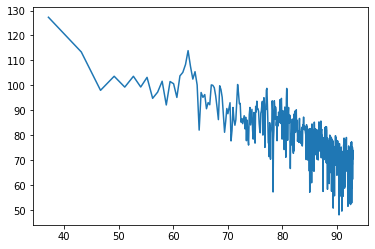

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:193: RuntimeWarning: divide by zero encountered in log10


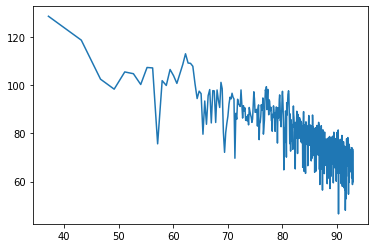

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:193: RuntimeWarning: divide by zero encountered in log10


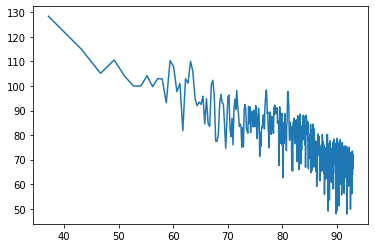

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:193: RuntimeWarning: divide by zero encountered in log10


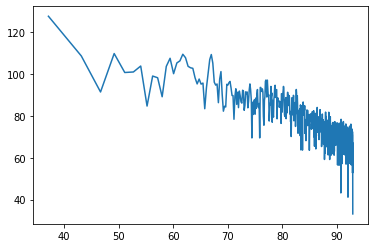

4


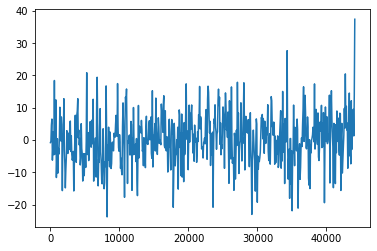

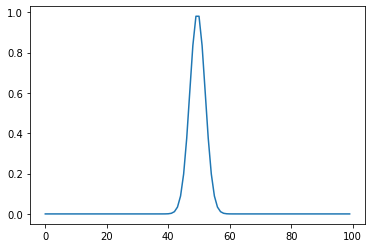

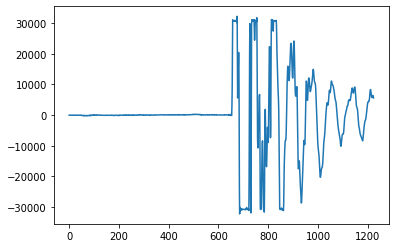

In [3]:
channels =1
rate = 44100
index = 0
frames = 5
chunk = 1024//5
tapSize = 6
detector = TapDetector(channels,rate,index,frames,chunk,tapSize)
detector.detectFromFile("test4buttons50training.wav")
detector.callibrate(4,50)
#detector.save("x.wav")
detector.detectFromMic(channels,index,frames)
#detector.callibrate(2,2)
detector.ButtonFreqPrint()
#detector.start(60)
detector.plot()
detector.stop()

In [ ]:
        
    def findPeaks(this,soundSlice,threshold):
        diff = np.diff(soundSlice)
        startPeak,startId = 0,0
        lowPeak,lowId = 0,0
        afterPeak, afterId = 0,0
        index = 0
        for db in soundSLice:
            index += 1
            if(lowId = 0 and db > 0 and db > startPeak and db >= threshold):
                startPeak = db
                startId = index
            elif(afterId = 0 and db < 0 and db < lowPeak):
                lowPeak = db,
                lowId = index
            elif(index > lowId and db > 0 and db > afterPeak):
                afterPeak = db
                afterId = index
            elif(after)